In [13]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches

from math import inf, pi
from itertools import product

%matplotlib inline

In [88]:
def collision_check():
    pass

In [89]:
def intersect(tri1, tri2):
    pass

In [91]:
def compute_configuration_space(piano, grid):
    '''sweep through grid checking for triangle intersections'''
    configuration_space = np.zeros_like(grid)
    for x in np.arange(0, 10, 0.1):
        for y in np.arange(0, 10, 0.1):
            for theta in np.arange(0, 2*pi, 0.05):
                if False:
                    configuration_space[x, y, theta] = collision_check()
    
    return configuration_space

In [92]:
def make_piano(offset):
    vertices = np.array([[0.0, 0.0], [0.0, 2.0], [0.5, 2.2], 
        [1.0, 2.0], [1.2, 1.2], [1.5, 1.0], [1.5, 0.0]])
    xy = vertices + offset
    piano = matplotlib.patches.Polygon(xy=xy)
    return piano

In [93]:
def make_obstacles():
    wall_1 = matplotlib.patches.Rectangle(xy=(5, 0), angle=0, height=2, width=0.2)
    wall_2 = matplotlib.patches.Rectangle(xy=(5, 5), angle=0, height=2, width=0.2)
    obstacles = [wall_1, wall_2]
    return obstacles

In [94]:
def plot_world(patches, goal=(8, 2)):
    fig, ax = plt.subplots()
    for patch in patches:
        ax.add_patch(patch)
        ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    ax.scatter(goal[0], goal[1])
    plt.show()
    return ax

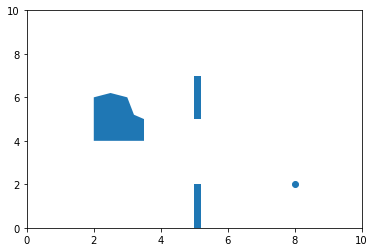

In [95]:
piano = make_piano(offset=np.array([2, 4]))
obstacles = make_obstacles()

patches = [piano] + obstacles
ax = plot_world(patches)

In [99]:
def main():
    pass

In [ ]:
if __name__ == '__main__':
    main()